## 1. Import Libraries and Load Data

In [3]:
# Libraries
import warnings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# Set-up environment
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="whitegrid", context="paper")
os.chdir('/Users/nataschajademinnitt/Documents/5. Data Analysis/segmenting_customers/')
print("Current directory:", os.getcwd())
warnings.filterwarnings("ignore")

Current directory: /Users/nataschajademinnitt/Documents/5. Data Analysis/segmenting_customers


In [154]:
# Load the data
df = pd.read_csv("./data/processed/processed_database.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72612 entries, 0 to 72611
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   recency                 72612 non-null  int64  
 1   f_orders                72612 non-null  int64  
 2   f_products              72612 non-null  int64  
 3   f_returning             72612 non-null  int64  
 4   m_price_log             72612 non-null  float64
 5   m_freight_log           72612 non-null  float64
 6   m_pct_freight           72612 non-null  float64
 7   m_credit                72612 non-null  float64
 8   m_total_installments    72612 non-null  float64
 9   m_purchasing_power      72612 non-null  int64  
 10  m_value_installments    72612 non-null  float64
 11  s_review_score          72612 non-null  float64
 12  s_delivery_diff         72612 non-null  float64
 13  s_delivery_diff_binary  72612 non-null  int64  
 14  product_score           72612 non-null

## 2. Functions

In [63]:
def evaluate_clusters(
    data,
    feature_cols=None,
    metric="distortion",
    k_min=2,
    k_max=10,
    random_state=42
):
    """
    Evaluate clustering (elbow, silhouette, intercluster distance) for a set of features.
    
    If `feature_cols` is None, uses *all* numeric columns in `data`.
    """
    # 1) Auto‑pick your features if none specified
    if feature_cols is None:
        # pick all numeric (incl. bool) columns
        feature_cols = data.select_dtypes(include=[np.number]).columns.tolist()

    # 2) Subset & scale once
    X = data[feature_cols].values
    scaler = MinMaxScaler().fit(X)
    X_scaled = scaler.transform(X)

    # 3) Make your 3‑panel canvas
    fig, axes = plt.subplots(3, 1, figsize=(6, 10))

    # 4) Elbow
    kelbow = KElbowVisualizer(
        KMeans(random_state=random_state),
        k=(k_min, k_max),
        metric=metric,
        ax=axes[0]
    )
    kelbow.fit(X_scaled)
    best_k = kelbow.elbow_value_
    kelbow.finalize()

    # 5) Silhouette
    silvis = SilhouetteVisualizer(
        KMeans(n_clusters=best_k, random_state=random_state),
        ax=axes[1]
    )
    silvis.fit(X_scaled)
    silvis.finalize()

    # 6) Inter‑cluster distances
    icd = InterclusterDistance(
        KMeans(n_clusters=best_k, random_state=random_state),
        ax=axes[2]
    )
    icd.fit(X_scaled)
    icd.finalize()

    plt.tight_layout()
    plt.show()

    return best_k, fig

In [13]:
def best_k_by_calinski(X, k_list, scale=True):
    """
    Returns the K in k_list with the highest Calinski–Harabasz score.
    """
    if scale:
        X_proc = RobustScaler().fit_transform(X)
    else:
        X_proc = X

    scores = {}
    for k in k_list:
        labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_proc)
        scores[k] = calinski_harabasz_score(X_proc, labels)

    best_k = max(scores, key=scores.get)
    return best_k, scores

In [15]:
def best_k_by_davies(
    X,
    k_list,
    scale: bool = True,
    scaler: object = RobustScaler(),
    random_state: int = 42
):
    """
    Returns the K in k_list with the lowest Davies–Bouldin score.
    """
    if scale:
        X_proc = scaler.fit_transform(X)
    else:
        X_proc = X


    scores = {}
    for k in k_list:
        labels = KMeans(n_clusters=k, random_state=random_state).fit_predict(X_proc)
        scores[k] = davies_bouldin_score(X_proc, labels)

    best_k = min(scores, key=scores.get)
    return best_k, scores

## 3. Comparing Models

In [88]:
def evaluate_feature_sets(
    df,
    dict_features,
    k_min: int = 2,
    k_max: int = 10,
    random_state: int = 42
) -> pd.DataFrame:
    """
    For each named feature‐set in dict_features, compute:
      - best_k_elbow   (using inertia elbow between k_min and k_max)
      - silhouette_score (at that k)
      - calinski_harabasz_score (at that k)
      - davies_bouldin_score (at that k)

    Assumes all columns in each feature‐list are numeric. Uses StandardScaler.
    """
    results = []

    for name, cols in dict_features.items():
        X = df[cols].values
        
        # 1) scale once
        X_scaled = MinMaxScaler().fit_transform(X)
        
        # 2) find best K via elbow (inertia)
        model = KMeans(random_state=random_state)
        viz = KElbowVisualizer(
            model,
            k=(k_min, k_max),
            metric='distortion',
            timings=False
        )
        viz.fit(X_scaled)
        best_k = viz.elbow_value_
        
        # 3) fit with best_k and compute internal scores
        labels = KMeans(n_clusters=best_k, random_state=random_state).fit_predict(X_scaled)
        
        sil = silhouette_score(X_scaled, labels)
        ch  = calinski_harabasz_score(X_scaled, labels)
        db  = davies_bouldin_score(X_scaled, labels)
        
        results.append({
            'feature_set': name,
            'best_k_elbow': best_k,
            'silhouette_score': sil,
            'calinski_harabasz_score': ch,
            'davies_bouldin_score': db
        })

    return pd.DataFrame(results)

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72612 entries, 0 to 72611
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   recency                 72612 non-null  int64  
 1   f_orders                72612 non-null  int64  
 2   f_products              72612 non-null  int64  
 3   f_returning             72612 non-null  int64  
 4   m_price_log             72612 non-null  float64
 5   m_freight_log           72612 non-null  float64
 6   m_pct_freight           72612 non-null  float64
 7   m_credit                72612 non-null  float64
 8   m_total_installments    72612 non-null  float64
 9   m_purchasing_power      72612 non-null  int64  
 10  s_review_score          72612 non-null  float64
 11  s_delivery_diff         72612 non-null  float64
 12  s_delivery_diff_binary  72612 non-null  int64  
 13  product_score           72612 non-null  float64
dtypes: float64(8), int64(6)
memory usage: 

In [165]:
# Keep
dict_features = {
    # 1) RFMR baseline + m_value_installments
    'rfm'          : ['recency', 'f_orders', 'f_returning', 'm_price_log'],
    
    # 2) RFMR + purchasing power (wealth proxy) + m_value_installments
    'rfmr_pp'       : ['recency', 'f_orders', 'f_returning', 'm_price_log',
                       'm_purchasing_power'],

    # 2) RFMR + without orders + m_value_installments
    'rfmmm'       : ['recency', 'f_returning', 'm_price_log',
                       'm_purchasing_power'],
}

,feature_set,best_k_elbow,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,rfmr,3,0.54,151201.25,0.59
1,rfmr_pp,5,0.59,117601.98,0.58
2,rfmmm,5,0.59,118055.48,0.58


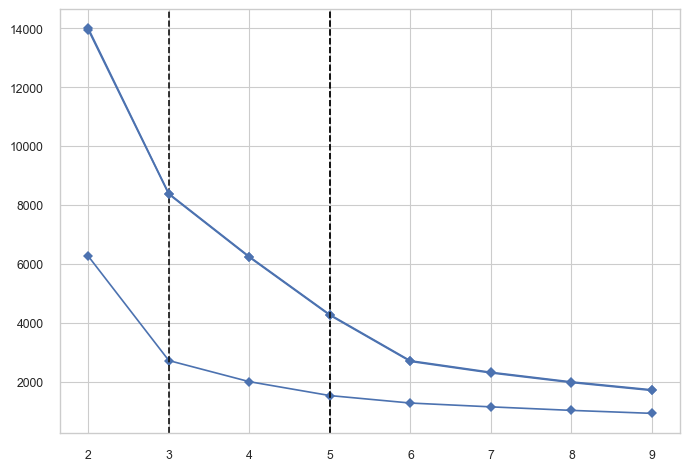

In [167]:
# Min Max scaler
results_df = evaluate_feature_sets(df, dict_features, k_min=2, k_max=10)
results_df

,feature_set,best_k_elbow,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,rfmr,3,0.54,151434.64,0.59
1,rfmr_pp,5,0.59,117741.99,0.58
2,rfmr_inst,3,0.52,143984.40,0.61
3,rfmr_deliv,4,0.55,115333.05,0.55
4,rfmr_pp_inst,5,0.58,114009.76,0.60
5,rfmr_pp_deliv,4,0.60,63706.67,0.83
6,rfmr_inst_deliv,4,0.54,110869.14,0.57
7,rfmr_full,4,0.59,62819.66,0.83


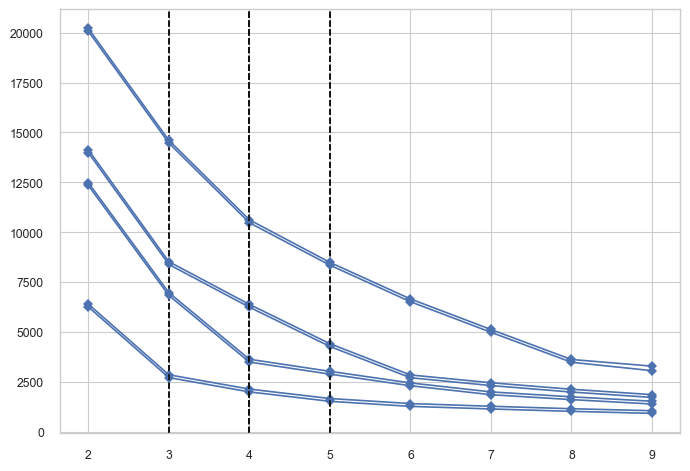

In [113]:
# Min Max scaler
results_df = evaluate_feature_sets(df, dict_features, k_min=2, k_max=10)
results_df

## Best combination of features

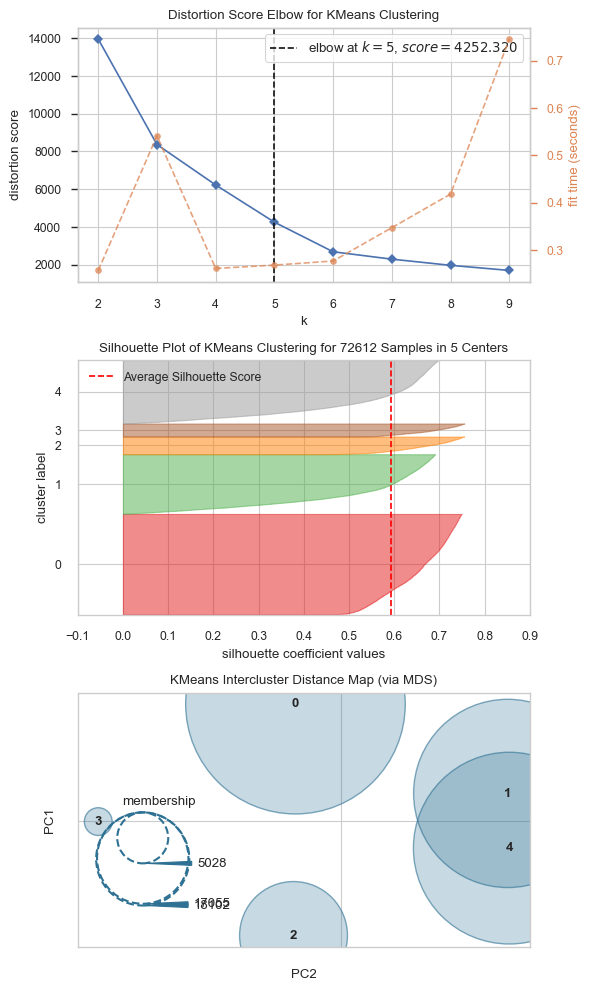

Optimal number of clusters according to the elbow for RFMR: 5


In [169]:
# Evaluate clusters: RFMR
best_k, fig = evaluate_clusters(
    data=df,
    feature_cols=dict_features['rfmmm'],
    metric="distortion",
    k_min=2,
    k_max=10
)

print("Optimal number of clusters according to the elbow for RFMR:", best_k)

In [70]:
def plot_cluster_radar(df, title="Cluster Radar Plot"):
    """
    Create a radar (spider) plot for cluster profiles.

    Parameters
    ----------
    df : pandas.DataFrame
        Each row is a cluster, each column a feature. Values should be comparable
        (e.g., normalized or scaled to [0,1]).
    title : str, default "Cluster Radar Plot"
        Title for the chart.

    Usage:
        # df_cluster_means: index = cluster labels, columns = features
        plot_cluster_radar(df_cluster_means, title="RFM Cluster Profiles")
    """
    # Number of variables
    features = df.columns.tolist()
    num_vars = len(features)

    # Compute angles for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # complete the loop

    # Setup polar plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    fig.suptitle(title, fontsize=14, fontweight='bold')

    # Plot each cluster
    for idx, row in df.iterrows():
        values = row.values.flatten().tolist()
        values += values[:1]  # complete the loop
        ax.plot(angles, values, linewidth=2, label=str(idx))
        ax.fill(angles, values, alpha=0.25)

    # Add feature labels on the axes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)

    # Hide radial grid labels (optional)
    ax.set_yticks([])

    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    plt.tight_layout()
    plt.show()

In [175]:
# 1) Define your RFMR feature list (make sure this matches what you used)
rfmr_feats = ['recency', 'f_orders', 'f_returning', 'm_price_log', 'm_value_installments']

# 2) Subset and scale
X = df[rfmr_feats]
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)

# 3) Fit KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled)
labels = kmeans.labels_

# 4) Build a DataFrame with scaled features + cluster labels
df_r = pd.DataFrame(X_scaled, columns=rfmr_feats)
df_r['cluster'] = labels

# 5) Compute the mean profile for each cluster
cluster_profiles = df_r.groupby('cluster').mean()

# 7) Inspect
print(cluster_profiles)

         recency  f_orders  f_returning  m_price_log  m_value_installments
cluster                                                                   
0           0.47      0.06         1.00         0.49                  0.01
1           0.24      0.00         0.00         0.43                  0.01
2           0.71      0.00         0.00         0.43                  0.01


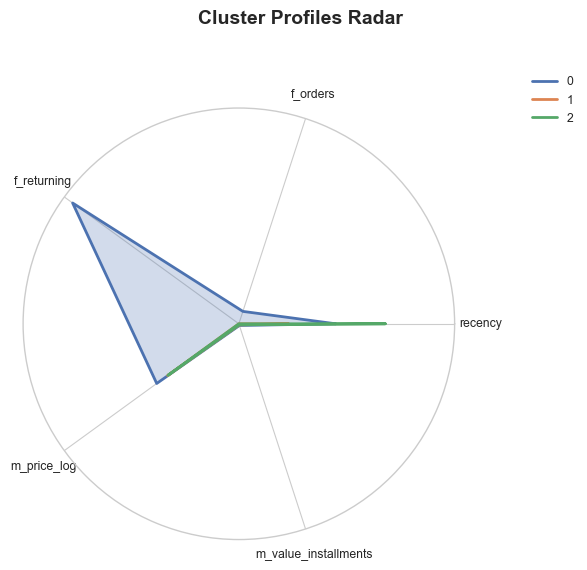

In [177]:
# Suppose `cluster_profiles` is a DataFrame:
# index = cluster label, columns = normalized feature values
plot_cluster_radar(cluster_profiles, title="Cluster Profiles Radar")

## Old

In [17]:
# Calinski-Harabasz (CH) index
feature_cols = [c for c in df.columns if c!='customer_unique_id']
X = df[feature_cols].values

k_list = range(2, 7)
best_k, all_scores = best_k_by_calinski(X, k_list, scale=True)

print("CH scores by K:", all_scores)
print("Best K according to CH:", best_k)

CH scores by K: {2: 20087.112970932678, 3: 16977.454738681492, 4: 15553.70163852409, 5: 13626.8546517212, 6: 12579.688739908843}
Best K according to CH: 2


In [19]:
# Davies–Bouldin scores
feature_cols = [c for c in df.columns if c != 'customer_unique_id']
X = df[feature_cols].values

k_list = range(2, 7)

best_k_db, db_scores = best_k_by_davies(X, k_list, scale=True)

print("Davies–Bouldin scores by K:", db_scores)
print("Best K (lowest DB):", best_k_db)

Davies–Bouldin scores by K: {2: 1.4929706692267162, 3: 1.7941203706146513, 4: 1.5945761902660542, 5: 1.6360159373502778, 6: 1.7750167682816533}
Best K (lowest DB): 2


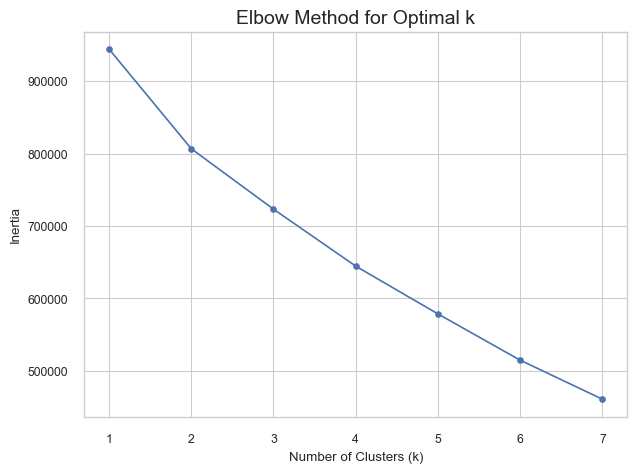

In [8]:
features = df.drop(columns=['customer_unique_id'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

inertias = []
k_range = range(1, 8)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow
plt.figure(figsize=(7,5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.xticks(k_range)
plt.grid(True)
plt.savefig(f"./results/figures/elbow_method_for_optimal_K.png")
plt.show()

The inertia (or within-cluster sum of squares) steadily decreases as k increases from 1 to 7 without a clear bend (elbow). This often suggests that the dataset does not have a strongly defined “natural” number of clusters according to inertia alone.

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

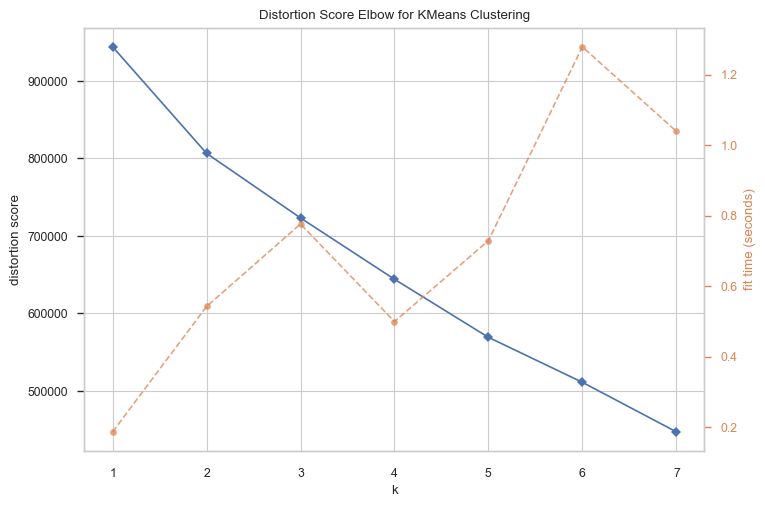

In [10]:
# Yellowbrick visualiser
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 8))

visualizer.fit(X_scaled)    # Fit the data to the visualizer
visualizer.poof(outpath="./results/figures/elbow_method_for_optimal_K.png")

The silhouette score ranges from -1 to 1, with higher values indicating better cluster separation. A lower score suggests that on average, the data points are only marginally better clustered than if they were assigned randomly.

In [46]:
# Silohette analysis
range_n_clusters = [3, 4, 5, 6]
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is: {silhouette_avg:.3f}")

NameError: name 'X_scaled' is not defined

The Calinski-Harabasz (CH) index measures the ratio of between-cluster dispersion to within-cluster dispersion. Higher values generally indicate better-defined clusters.

In [14]:
# Calinski-Harabasz (CH) index
range_n_clusters = [3, 4, 5, 6]
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    ch_score = calinski_harabasz_score(X_scaled, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average calinski-Harabasz score is: {ch_score:.3f}")

For n_clusters = 3, the average calinski-Harabasz score is: 11090.868
For n_clusters = 4, the average calinski-Harabasz score is: 11249.002
For n_clusters = 5, the average calinski-Harabasz score is: 11467.318
For n_clusters = 6, the average calinski-Harabasz score is: 12113.542


The Davies-Bouldin (DB) index evaluates the average similarity between each cluster and its most similar one, where lower values indicate better clustering (i.e., more separation between clusters).

In [22]:
# Davies-Bouldin (DB) index
range_n_clusters = [3, 4, 5, 6]
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    db_score = davies_bouldin_score(X_scaled, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the Davies-Bouldin score is: {db_score:.3f}")

For n_clusters = 3, the Davies-Bouldin score is: 1.901
For n_clusters = 4, the Davies-Bouldin score is: 1.469
For n_clusters = 5, the Davies-Bouldin score is: 1.333
For n_clusters = 6, the Davies-Bouldin score is: 1.400


### Final cluster selection

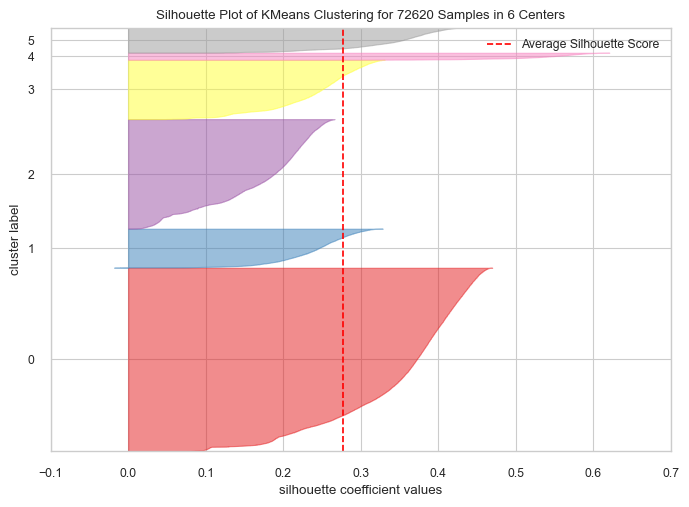

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 72620 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [222]:
# Instantiate the clustering model and visualizer 
model = KMeans(6)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_scaled)
visualizer.poof()